In [3]:
# импортируем библиотеки
import math
import numpy as np
import scipy.integrate as integrate   # для решения ОДУ в методе DEM
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

# выставляем размер шрифта подписей осей ко всем графикам
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12) 

In [4]:
# импортируем из другого Jupyter Notebook формулы для решения прямой задачи
%run ./FP_formulas.ipynb

# Задача

In [5]:
# создадим данные
N = 50   # количество отсчетов в скважине
true_por_loc = 15   # мат. ожидание пористости
true_por_scale = 5   # дисперсия пористости
true_asp_loc = 0.4
true_asp_scale = 0.1

# список со значениями пористости
porosity_list = np.around(np.random.normal(loc = true_por_loc, scale = true_por_scale, size = N), decimals = 2)
quarz_list = []

# список со значениями аспектного отношения
aspect_ratio_list = np.around(np.random.normal(loc = true_asp_loc, scale = true_asp_scale, size = N), decimals = 3)

# уберем значения пористости и аспектного отношения, которые оказались меньше нуля
for i in range(len(porosity_list)):
    if porosity_list[i] < 0:
        porosity_list[i] = true_por_loc
    quarz_list.append(round(100 - porosity_list[i], 2))
    
    if aspect_ratio_list[i] <= 0:
        aspect_ratio_list[i] = true_asp_loc4
    

porosity_list = np.ndarray.tolist(porosity_list)
aspect_ratio_list = np.ndarray.tolist(aspect_ratio_list)

# зададим номинальную глубину скважины
depth = np.arange(3000, 3000 + N, 1)

In [6]:
# зафиксируем на всякий случай скважинные данные, чтобы дальше с ними работать
porosity_list = [16.21, 19.92, 10.82, 7.56, 12.71, 10.66, 17.34, 10.18, 13.51, 8.43, 10.93, 22.47, 14.59, 15.64, 15.13, 21.19, 21.39, 15.82, 5.75, 14.55, 16.27, 13.74, 16.78, 17.52, 19.22, 11.7, 9.28, 14.32, 9.14, 11.62, 21.06, 4.43, 15.96, 9.07, 18.44, 18.76, 16.82, 11.99, 17.33, 10.6, 16.34, 15.49, 10.19, 14.78, 7.71, 9.86, 19.11, 16.73, 16.1, 11.82]
quarz_list = [83.79, 80.08, 89.18, 92.44, 87.29, 89.34, 82.66, 89.82, 86.49, 91.57, 89.07, 77.53, 85.41, 84.36, 84.87, 78.81, 78.61, 84.18, 94.25, 85.45, 83.73, 86.26, 83.22, 82.48, 80.78, 88.3, 90.72, 85.68, 90.86, 88.38, 78.94, 95.57, 84.04, 90.93, 81.56, 81.24, 83.18, 88.01, 82.67, 89.4, 83.66, 84.51, 89.81, 85.22, 92.29, 90.14, 80.89, 83.27, 83.9, 88.18]
aspect_ratio_list = [0.355, 0.371, 0.339, 0.477, 0.266, 0.368, 0.223, 0.528, 0.454, 0.345, 0.521, 0.439, 0.331, 0.469, 0.324, 0.531, 0.573, 0.444, 0.229, 0.279, 0.283, 0.273, 0.381, 0.2, 0.561, 0.243, 0.381, 0.456, 0.483, 0.496, 0.358, 0.266, 0.329, 0.448, 0.362, 0.498, 0.366, 0.429, 0.377, 0.408, 0.459, 0.383, 0.367, 0.507, 0.336, 0.506, 0.362, 0.369, 0.281, 0.365]

In [7]:
# нарисуем скважину
def draw_MCM(depth, quarz_list, porosity_list, aspect_ratio_list):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

    turquoise = '#40E0D0'

    axes[0].set_title('Well Mineral Content', fontsize = 18)
    axes[0].barh(depth, quarz_list, color = 'grey')
    axes[0].barh(depth, porosity_list, color = turquoise, left = quarz_list)
    axes[0].set_xlabel('conponents volume (%)', fontsize = 14)
    axes[0].set_ylabel('depth (meters)', fontsize = 14)
    axes[0].set_ylim(max(depth), min(depth))
    axes[0].legend(['quarz', 'effective porosity'], fontsize = 14,
              bbox_to_anchor=(3.3, 1))


    axes[1].plot(aspect_ratio_list, depth, c = 'r', linewidth = 1.5)
    axes[1].set_title('Aspect Ratio \n of Pore Inclusions', fontsize = 18)
    axes[1].yaxis.set_visible(False)
    axes[1].set_ylim(max(depth), min(depth))

    plt.show()

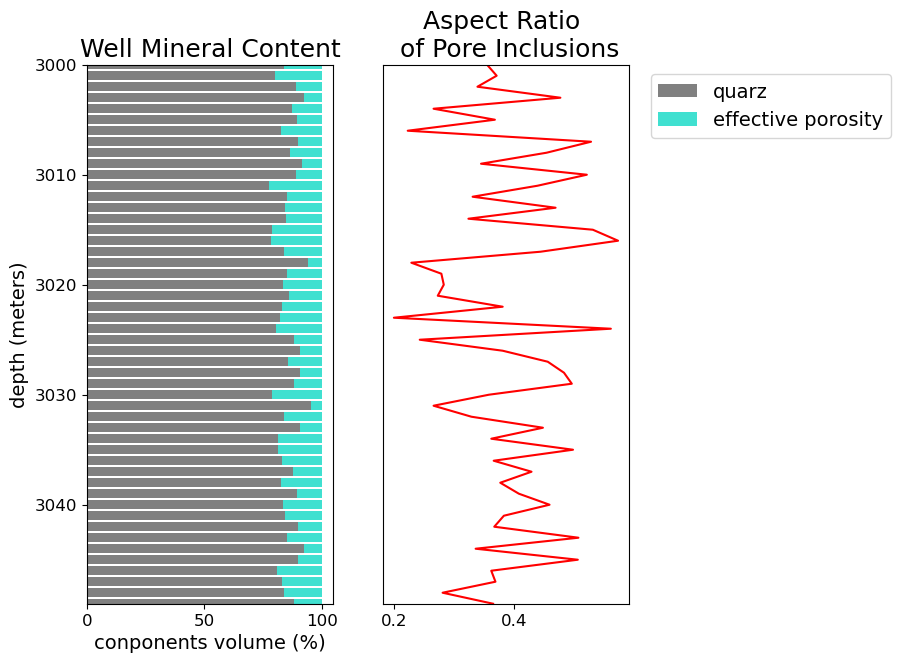

In [8]:
draw_MCM(depth, quarz_list, porosity_list, aspect_ratio_list)

In [9]:
# упругие модули
quarz_moduli = [45, 20]
fluid_moduli = [2.5, 0]


# плотности
rho_components = [2.71, 1]

# Решение

## Прямая задача 

In [10]:
def do_forward_problem(porosity, aspect_ratio, quarz_moduli = [45, 20], fluid_moduli = [2.5, 0], rho_components = [2.71, 1]):
    
    # кварц + поры по DEM
    inclusions = [0, 0]   # вносим поры, не насыщенные ничем
    moduli = solve_DEM(quarz_moduli, inclusions, aspect_ratio, porosity)
    
    # насытим породу
    moduli_saturated = solve_Gassmann(moduli, quarz_moduli, fluid_moduli, porosity)

    # рассчитаем общую плотность
    rho = rho_components[1] * porosity/100 + rho_components[0] * (100 - porosity)/100
    
    # рассчитаем скорости Vp и Vs
    vp, vs = get_velocity(rho, moduli_saturated)

    return vp, vs, rho

In [11]:
def get_velocities_in_well(porosity_list, aspect_ratio_list):
    
    true_well_vp = []
    true_well_vs = []
    true_well_rho = []
    
    for i in range(len(porosity_list)):
        porosity = porosity_list[i]
        aspect_ratio = aspect_ratio_list[i]
        
        vp_sample, vs_sample, rho_sample = do_forward_problem(porosity, aspect_ratio)
        
        true_well_vp.append(vp_sample)
        true_well_vs.append(vs_sample)
        true_well_rho.append(rho_sample)
    
    return true_well_vp, true_well_vs, true_well_rho                                       

In [12]:
# решим прямую задачу для исходных данных
true_well_vp, true_well_vs, true_well_rho = get_velocities_in_well(porosity_list, aspect_ratio_list)

In [13]:
# нарисуем графики с решенной прямой задачей
def draw_FP(depth, true_well_vp, true_well_vs, true_well_rho, quarz_list, porosity_list, aspect_ratio_list, true_asp_loc):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(13, 7))
    
    turquoise = '#40E0D0'

    # скорость Vp
    axes[0].plot(true_well_vp, depth, c = 'k')
    axes[0].set_ylim(bottom = max(depth), top = min(depth))
    axes[0].set_title('P-wave \n Velocity', fontsize = 16)
    axes[0].set_xlabel('velocity (km/s)', fontsize = 14)
    axes[0].set_ylabel('depth (meters)', fontsize = 14)

    # скорость Vs
    axes[1].plot(true_well_vs, depth, c = 'k')
    axes[1].set_ylim(bottom = max(depth), top = min(depth))
    axes[1].yaxis.set_visible(False)
    axes[1].set_title('S-wave \n Velocity', fontsize = 16)
    axes[1].set_xlabel('velocity (km/s)', fontsize = 14)

    # плотность
    axes[2].plot(true_well_rho, depth, c = 'k')
    axes[2].set_ylim(bottom = max(depth), top = min(depth))
    axes[2].set_title('Rock Density', fontsize = 16)
    axes[2].set_xlabel('density (g/cm3)', fontsize = 14)
    axes[2].yaxis.set_visible(False)

    # минеральная колонка
    axes[3].barh(depth, quarz_list, color = 'grey')
    axes[3].barh(depth, porosity_list, color = turquoise, left = quarz_list)
    axes[3].set_xlabel('conponents volume (%)', fontsize = 14)
    axes[3].set_ylim(bottom = max(depth), top = min(depth))
    axes[3].legend(['quarz', 'effective \n porosity'], fontsize = 14, bbox_to_anchor=(3.3, 1.01))
    axes[3].yaxis.set_visible(False)
    axes[3].set_title('Mineral \n Component', fontsize = 16)
    axes[3].set_xlabel('volume (%)', fontsize = 14)

    # аспектное отношение
    aspect_mead = [true_asp_loc for i in range(len(porosity_list))]
    axes[4].plot(aspect_mead, depth, c = 'grey')
    axes[4].plot(aspect_ratio_list, depth, c = 'k', linewidth = 1.5)
    axes[4].set_title('Aspect Ratio \n of Pore Inclusions', fontsize = 16)
    axes[4].yaxis.set_visible(False)
    axes[4].set_ylim(max(depth), min(depth))

    fig.tight_layout()

C:\Users\vdvor\AppData\Local\Temp\ipykernel_10668\3631366629.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


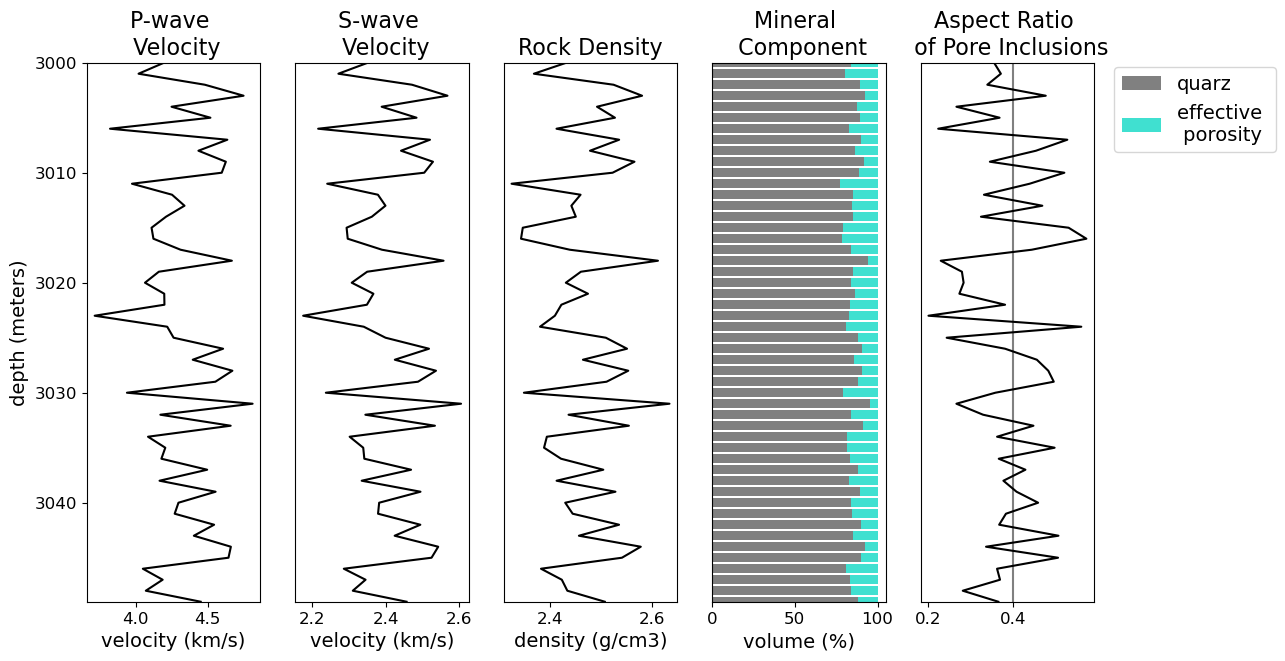

In [14]:
draw_FP(depth, true_well_vp, true_well_vs, true_well_rho, quarz_list, porosity_list, aspect_ratio_list, true_asp_loc)

# Обратная задача

## Монте-Карло 

In [15]:
# вычисляет невязку между исходными и инвертированными значениями скорости,
# на вход подаются исходные (vp_true, vs_true) и инвертированные (vp_sample, vs_sample) значения скорости (type = float),
# а также заранее заданная ошибка allowable error (float)

def check_how_close(vp_true, vs_true, rho_true, vp_sample, vs_sample, rho_sample, allowable_error, weights):
    
    #error_all = allowable_error[0]
    #error_vp = allowable_error[1]
    #error_vs = allowable_error[2]
    #error_rho = allowable_error[3]
    
    weight_vp = weights[0]
    weight_vs = weights[1]
    weight_rho = weights[2]
    
    error = math.sqrt(weight_vp*((vp_true - vp_sample)/vp_true)**2 + weight_vs*((vs_true - vs_sample)/vs_true)**2 + 
                      weight_rho*((rho_true - rho_sample)/rho_true)**2)
    
    # если невязка удовлетворяет заранее заданному значения (allowable_error), функция возвращает True, иначе False
    if error < allowable_error:
        return True
    else:
        return False

In [16]:
# реализует метод Монте-Карло
# на вход подается функция для вычисления прямой задачи do_forward_problem, истинные значения скорости (vp_true, vs_true;
# type = float), N - количество настрелов (type - int), allowable_error - допустимая ошибка (type = float)

def do_monte_carlo(do_forward_problem, vp_true, vs_true, rho_true, sample_number, allowable_error, weights,
                   por_loc, por_scale, aspect_loc, aspect_scale):
    
    # создаются пустые массивы, которые будут заполняться инвертированными данными
    good_porosity = []
    good_aspect_ratio = []
    all_sample_numbers = 0  # трекер итераций
    
    while len(good_porosity) < sample_number:
        
        all_sample_numbers += 1
        
        # настреливаются значения пористости по нормальному закону распределения
        por = np.random.normal(loc = por_loc, scale = por_scale)
        
        # настреливаются значения аспектного отношения пор
        aspect = np.random.normal(loc = aspect_loc, scale = aspect_scale)
        
        # убираются значения пористости и аспектного отношения, которые меньше или равны нулю
        if por <= 0:
            por = por_loc
        if aspect <= 0:
            aspect = aspect_loc

        vp_sample, vs_sample, rho_sample = do_forward_problem(por, aspect)
        check = check_how_close(vp_true, vs_true, rho_true, vp_sample, vs_sample, rho_sample, allowable_error, weights)
        
        if check == True:
            good_porosity.append(por)
            good_aspect_ratio.append(aspect)
    
    avg_por = sum(good_porosity) / len(good_porosity)
    avg_aspect = sum(good_aspect_ratio) / len(good_aspect_ratio)

    return avg_por, avg_aspect, all_sample_numbers

In [17]:
from time import time

def do_inverse_problem(true_well_vp, true_well_vs, true_well_rho, sample_number, allowable_error, weights,
                      por_loc, por_scale, aspect_loc, aspect_scale, file_name = 'quarz_well(1)_RESULTS.txt'):
    
    inverse_porosity_list = []
    inverse_aspect_ratio_list = []
    all_sample_numbers_list = []
    
    start = time()
    for i in range(len(true_well_vp)):
        
        vp_true = true_well_vp[i]
        vs_true = true_well_vs[i]
        rho_true = true_well_rho[i]
        
        avg_por, avg_aspect, all_sample_numbers = do_monte_carlo(do_forward_problem, vp_true, vs_true, rho_true,
                                                                 sample_number, allowable_error, weights, 
                                                                 por_loc, por_scale, aspect_loc, aspect_scale)
        
        inverse_porosity_list.append(avg_por)
        inverse_aspect_ratio_list.append(avg_aspect)
        all_sample_numbers_list.append(all_sample_numbers)
        
    end = time()
    
    all_samples_number = sum(all_sample_numbers_list)/len(all_sample_numbers_list)
    
    inverse_porosity_to_file = ', '.join(str(e) for e in inverse_porosity_list)
    inverse_aspect_to_file = ', '.join(str(e) for e in inverse_aspect_ratio_list)
    
    # запишем результаты в файл
    file_object = open(file_name, 'a')
    file_object.write('por_loc = {0}\n'.format(str(por_loc)))
    file_object.write('por_scale = {0}\n'.format(str(por_scale)))
    file_object.write('aspect_loc = {0}\n'.format(str(aspect_loc)))
    file_object.write('aspect_scale = {0}\n'.format(str(aspect_scale)))
    file_object.write('sample_number = {0}\n'.format(str(sample_number)))
    file_object.write('allowable_error = {0}\n'.format(str(allowable_error)))
    file_object.write('all_samples_number = {0}\n'.format(str(all_samples_number)))
    file_object.write('time(s) = {0}\n\n'.format(str(end - start)))
    
    file_object.write('inverse porosity:\n')
    file_object.write('{0}\n\n'.format(inverse_porosity_to_file))
    file_object.write('inverse aspect ratio:\n')
    file_object.write('{0}\n\n\n\n'.format(inverse_aspect_to_file))
    file_object.close()
    
    return(inverse_porosity_list, inverse_aspect_ratio_list, end - start, )

In [18]:
por_loc = 15
por_scale = 5
aspect_loc = 0.4
aspect_scale = 0.1

sample_number = 10
allowable_error = 0.03
weights = [1, 1, 5]

inverse_porosity_list, inverse_aspect_ratio_list, IP_time = do_inverse_problem(true_well_vp, true_well_vs, true_well_rho,
                                                                               sample_number, allowable_error, weights, 
                                                                               por_loc, por_scale, aspect_loc, aspect_scale)

In [20]:
# решим прямую задачу для ИНВЕРТИРОВАННЫХ данных
inverse_vp_list, inverse_vs_list, inverse_rho_list = get_velocities_in_well(inverse_porosity_list, inverse_aspect_ratio_list)

In [21]:
# нарисуем графики с решенной прямой задачей
def draw_IP(depth, true_well_vp, true_well_vs, true_well_rho, quarz_list, porosity_list, aspect_ratio_list, true_asp_loc,
            inverse_porosity_list, inverse_aspect_ratio_list, inverse_vp_list, inverse_vs_list, inverse_rho_list):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(13, 7))

    # скорость Vp
    axes[0].plot(true_well_vp, depth, c = 'k')
    axes[0].plot(inverse_vp_list, depth, c = 'r', linestyle = '--')
    axes[0].set_ylim(bottom = max(depth), top = min(depth))
    axes[0].set_title('P-wave \n Velocity', fontsize = 16)
    axes[0].set_xlabel('velocity (km/s)', fontsize = 14)
    axes[0].set_ylabel('depth (meters)', fontsize = 14)

    # скорость Vs
    axes[1].plot(true_well_vs, depth, c = 'k')
    axes[1].plot(inverse_vs_list, depth, c = 'r', linestyle = '--')
    axes[1].set_ylim(bottom = max(depth), top = min(depth))
    axes[1].yaxis.set_visible(False)
    axes[1].set_title('S-wave \n Velocity', fontsize = 16)
    axes[1].set_xlabel('velocity (km/s)', fontsize = 14)

    # плотность
    axes[2].plot(true_well_rho, depth, c = 'k')
    axes[2].plot(inverse_rho_list, depth, c = 'r', linestyle = '--')
    axes[2].set_ylim(bottom = max(depth), top = min(depth))
    axes[2].set_title('Rock Density', fontsize = 16)
    axes[2].set_xlabel('density (g/cm3)', fontsize = 14)
    axes[2].yaxis.set_visible(False)

    # пористость
    axes[3].plot(porosity_list, depth, c = 'k')
    axes[3].plot(inverse_porosity_list, depth, c = 'r', linestyle = '--')
    axes[3].set_ylim(bottom = max(depth), top = min(depth))
    axes[3].set_title('Effective \n Porosity', fontsize = 16)
    axes[3].set_xlabel('porosity (%)', fontsize = 14)
    axes[3].yaxis.set_visible(False)

    # аспектное отношение
    aspect_mead = [true_asp_loc for i in range(len(porosity_list))]
    axes[4].plot(aspect_mead, depth, c = 'grey')
    axes[4].plot(inverse_aspect_ratio_list, depth, c = 'r', linestyle = '--')
    axes[4].plot(aspect_ratio_list, depth, c = 'k', linewidth = 1.5)
    axes[4].set_title('Aspect Ratio \n of Pore Inclusions', fontsize = 16)
    axes[4].yaxis.set_visible(False)
    axes[4].set_ylim(max(depth), min(depth))

    fig.tight_layout()

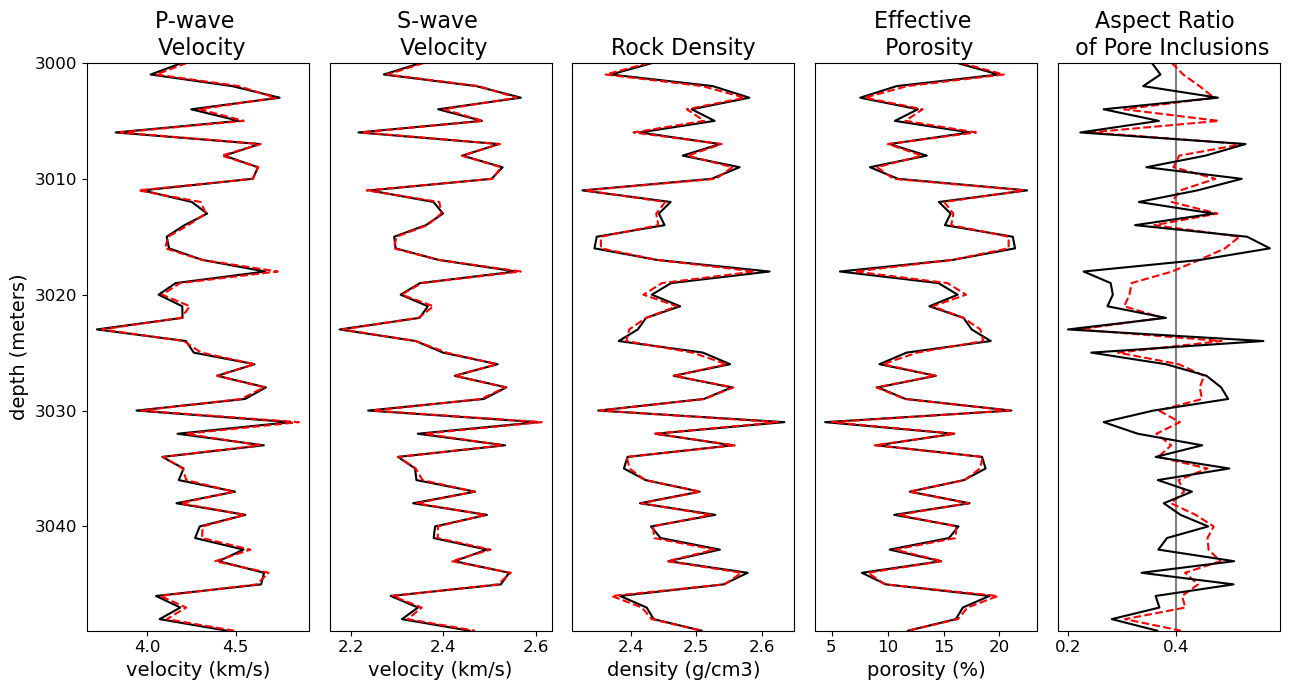

In [22]:
draw_IP(depth, true_well_vp, true_well_vs, true_well_rho, quarz_list, porosity_list, aspect_ratio_list, true_asp_loc, inverse_porosity_list, inverse_aspect_ratio_list, inverse_vp_list, inverse_vs_list, inverse_rho_list)